In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.optimize import fmin
import scipy.special as sp

import glob
import csv

plt.style.use('seaborn-darkgrid')

In [32]:
# You can try the 'method of constant' from the link below:
# https://shigeodayo.github.io/PsychophysicsWebExp/index.html
CSV_PATH = '../../../data/psychophysics/constant'  # Put the experimental data (CSVs) in this directory.
OUTPUT_PATH = 'output/'
if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
# HEADER = ['id', '10', '30', '50', '70', '90']
# HEADER = ['id', '10', '20', '30', '40', '50', '60', '70', '80', '90']
HEADER = ['id', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85'] # Should be updated depending on the parameters used in the study
# HEADER = ['id', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']
REPETITION = 4 # Should be updated depending on the parameters used in the study

In [33]:
# Read experimental data
ans_csvs = glob.glob(CSV_PATH + '/*.csv')
print('num of csvs: {}'.format(len(ans_csvs)))

num of csvs: 98


In [34]:
# Fetch answers and id from a specified csv file
def get_ans_series(ans_csv):
    with open(ans_csv) as f:
        reader = csv.reader(f)
        lines = [row for row in reader]
        # id = lines[0][1]
        ans_dict = {str(HEADER[i + 1]): 0 for i in range(len(HEADER) - 1)}
        for i, ans in enumerate(lines[2]):
            sample_lightness = lines[1][i]
            if ans == 'sample':
                ans_dict[sample_lightness] += 1
        series = pd.Series(ans_dict)
        # print(series)
        series['id'] = lines[0][1]
    return series

In [35]:
# Create a dataframe from csvs
ans_df = pd.DataFrame(columns=HEADER)
for ans_csv in ans_csvs:
    ans_series = get_ans_series(ans_csv)
    # print(id)
    # print(ans_series)
    ans_df = ans_df.append(ans_series, ignore_index=True)
print(ans_df)

           id 30 35 40 45 50 55 60 65 70 75 80 85
0   sy_ns76wl  0  0  0  2  3  4  4  4  4  4  4  4
1   sy_fdyofl  0  0  0  0  1  1  2  4  4  4  4  4
2   sy_seeqhq  0  0  0  1  4  4  4  4  4  4  4  4
3   sy_oxgwzk  0  0  0  1  3  0  2  3  4  4  4  4
4   sy_nxckap  0  0  1  3  4  4  4  4  4  4  4  4
..        ... .. .. .. .. .. .. .. .. .. .. .. ..
93  sy_sxtaak  0  0  0  1  2  4  4  4  4  4  4  4
94  sy_s6ftt9  0  0  0  3  4  3  4  4  4  4  4  4
95  sy_g3axyl  0  0  0  0  2  2  4  4  4  4  4  4
96  sy_ll62lc  0  0  0  2  4  4  4  4  4  4  4  4
97  sy_szlydn  0  0  0  1  2  3  4  4  4  4  4  4

[98 rows x 13 columns]


/var/folders/nn/v_np6l6j583bnc3t17fzmr480000gn/T/ipykernel_90607/2137497265.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans_df = ans_df.append(ans_series, ignore_index=True)
/var/folders/nn/v_np6l6j583bnc3t17fzmr480000gn/T/ipykernel_90607/2137497265.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans_df = ans_df.append(ans_series, ignore_index=True)
/var/folders/nn/v_np6l6j583bnc3t17fzmr480000gn/T/ipykernel_90607/2137497265.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans_df = ans_df.append(ans_series, ignore_index=True)
/var/folders/nn/v_np6l6j583bnc3t17fzmr480000gn/T/ipykernel_90607/2137497265.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

In [36]:
# Calculate probability from answers
X = pd.Series(list(map(lambda x : int(x), HEADER[1:])))
Y = [ans_df[x].mean() for x in HEADER[1:]]
Y_norm = pd.Series(list(map(lambda x: x / REPETITION, Y)))
# print(X)
# print(Y_norm)

In [37]:
# Error function, see below urls for more details:
# http://bigface00.hateblo.jp/entry/2018/03/31/170227
# http://kaji-lab.jp/kajimoto/ConstantMethodFitting.htm
def err(init_vals, x, y):
    sigma, mu = init_vals
    a = y - 0.5 - 0.5 * sp.erf((x - mu) / (math.sqrt(2) * sigma))
    return sum(a**2)

In [38]:
# Optimization
sigma, mu = fmin(err, np.array([1, X.mean()]), args=(X, Y_norm))

# fitted curve
# curve_x = np.linspace(min(X), max(X), 100)
curve_x = np.linspace(0, 100, 100)
curve_y = 0.5 + 0.5 * sp.erf((curve_x - mu) / (math.sqrt(2) * sigma))

# JND
bound25 = sp.erfinv(0.25 * 2 - 1) * math.sqrt(2) * sigma + mu
bound75 = sp.erfinv(0.75 * 2 - 1) * math.sqrt(2) * sigma + mu

print('PSE = {:.2f}, JND_25 = {:.2f}, JND_75 = {:.2f}'.format(mu, mu - bound25, bound75 - mu))

Optimization terminated successfully.
         Current function value: 0.033053
         Iterations: 65
         Function evaluations: 126
PSE = 47.07, JND_25 = 4.74, JND_75 = 4.74


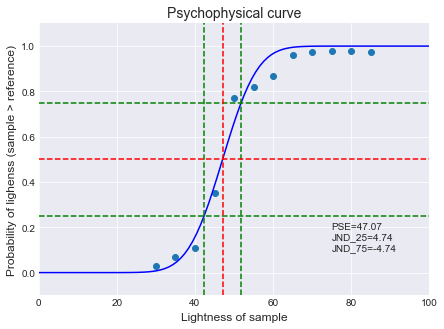

In [39]:
plt.figure(figsize=(7, 5))

# Plot dots
plt.plot(X, Y_norm, 'o')

# Plot curve
plt.plot(curve_x, curve_y, color='blue')

# JND
plt.plot([0.0, 100], [0.25, 0.25], linestyle = 'dashed',color="green")
plt.plot([0.0, 100], [0.75, 0.75], linestyle = 'dashed',color="green")
plt.plot([bound25, bound25], [-0.1, 1.1], linestyle='dashed', color="green")  # 25% threshold
plt.plot([bound75, bound75], [-0.1, 1.1], linestyle='dashed', color="green")  # 75% threshold

# PSE
plt.plot([0.0, 100], [0.50, 0.50], linestyle = 'dashed',color="red")
plt.plot([mu, mu], [-0.1, 1.1], linestyle='dashed', color="red")

plt.text(75, 0.1, 'PSE={:.2f}\nJND_25={:.2f}\nJND_75={:.2f}'.format(mu, mu - bound25, mu - bound75))

# Options
plt.title('Psychophysical curve', fontsize=14)
plt.xlabel('Lightness of sample', fontsize=12)
plt.ylabel('Probability of lighenss (sample > reference)', fontsize=12)
plt.ylim(-0.1, 1.1)
plt.xlim(0, 100)
# plt.legend()

plt.savefig(os.path.join(OUTPUT_PATH, 'constant.pdf'))
plt.show()